In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score

In [2]:
df_train = pd.read_csv("data/train.csv")
df_to_predict = pd.read_csv("data/test.csv")
ids = df_to_predict['Deal_id']

In [3]:
df = pd.concat([df_train, df_to_predict], ignore_index=True)

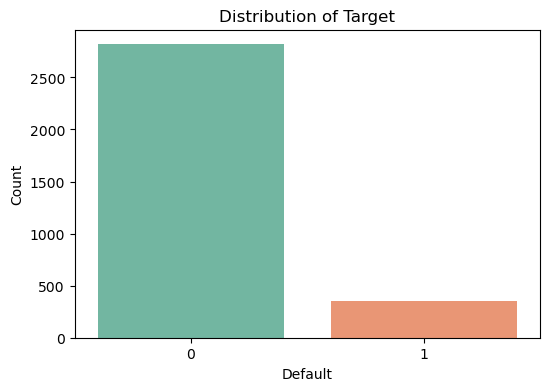

In [4]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df_train['Default'], palette='Set2')
plt.xlabel('Default')
plt.ylabel('Count')
plt.title('Distribution of Target')
plt.show()

We see that our target is unbalanced so we'll respect this fact during our work

### First introduction to data

In [5]:
df.head()

,Deal_id,Deal_date,First_deal_date,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,First_default_date,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Hashed_deal_detail_6,Age,Gender,Default
0,22487461,2015-11-05,2015-08-29,NaN,NaN,NaN,NaN,0.0,Tavern_district_3,7,2.5,-3,8,2.5,-3,5,36.0,Male,0.0
1,62494261,2016-08-26,2015-12-21,3.5,-2.0,5.0,2016-07-30,2.0,Tavern_district_4,7,2.5,-3,14,3.5,-3,5,29.0,Female,1.0
2,34822849,2016-02-18,2015-11-11,NaN,NaN,NaN,NaN,0.0,Tavern_district_6,7,2.5,-3,8,2.5,-3,5,56.0,Female,0.0
3,46893387,2016-04-30,2016-03-22,NaN,NaN,NaN,NaN,0.0,Tavern_district_2,13,2.5,-2,5,2.5,-3,5,27.0,Female,0.0
4,67128275,2016-09-19,2016-07-21,NaN,NaN,NaN,NaN,0.0,Tavern_district_4,39,2.5,-3,7,2.5,-3,5,37.0,Female,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4157 entries, 0 to 4156
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Deal_id                 4157 non-null   int64  
 1   Deal_date               4157 non-null   object 
 2   First_deal_date         4157 non-null   object 
 3   Secret_dwarf_info_1     675 non-null    float64
 4   Secret_dwarf_info_2     675 non-null    float64
 5   Secret_dwarf_info_3     675 non-null    float64
 6   First_default_date      675 non-null    object 
 7   Successful_deals_count  4142 non-null   float64
 8   Region                  4146 non-null   object 
 9   Tavern                  4157 non-null   int64  
 10  Hashed_deal_detail_1    4157 non-null   float64
 11  Hashed_deal_detail_2    4157 non-null   int64  
 12  Hashed_deal_detail_3    4157 non-null   int64  
 13  Hashed_deal_detail_4    4157 non-null   float64
 14  Hashed_deal_detail_5    4157 non-null   

### Working with NaN values

We found that the secret dwarf info contains a lot of null values, but as we discovered in the following experiments, they also matter, so we decided not to skip these columns

In [7]:
df['Secret_dwarf_info_1'].fillna(df['Secret_dwarf_info_1'].mean(), inplace=True)
df['Secret_dwarf_info_2'].fillna(df['Secret_dwarf_info_2'].mean(), inplace=True)
df['Secret_dwarf_info_3'].fillna(df['Secret_dwarf_info_3'].mean(), inplace=True)

Also we decided to fill NaN values in Region and Successful_deals_count columns with mode

In [8]:
most_frequent_region = df['Region'].mode()[0]
df['Region'].fillna(most_frequent_region, inplace=True)

most_frequent_deals_count = df['Successful_deals_count'].mode()[0]
df['Successful_deals_count'].fillna(most_frequent_deals_count, inplace=True)

### Working with data, generating new data features

In [9]:
#Create new column with binary information indicating whether there is a default

df['Was_a_default'] = df['First_default_date'].notna().astype(int)

In [10]:
#Converting data to datetime object

df['Deal_date'] = pd.to_datetime(df['Deal_date'])
df['First_deal_date'] = pd.to_datetime(df['First_deal_date'])

In [11]:
#Creating new data feature

df['Difference_deal_vs_first_deal'] = (df['Deal_date'] - df['First_deal_date']).dt.days

In [12]:
#Getting numerical features from datetime object

df['day_of_week'] = df['Deal_date'].dt.dayofweek
df['day_of_month'] = df['Deal_date'].dt.day
df['month'] = df['Deal_date'].dt.month
df['is_weekend'] = df['Deal_date'].dt.dayofweek >= 5    

### Encode categorical features

In [13]:
df = pd.get_dummies(df, columns=['Gender', 'Region'])

### Drop unusefull columns

In [14]:
df = df.drop(['Hashed_deal_detail_6','First_default_date', 'Deal_date', 'First_deal_date', 'Deal_id'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4157 entries, 0 to 4156
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Secret_dwarf_info_1            4157 non-null   float64
 1   Secret_dwarf_info_2            4157 non-null   float64
 2   Secret_dwarf_info_3            4157 non-null   float64
 3   Successful_deals_count         4157 non-null   float64
 4   Tavern                         4157 non-null   int64  
 5   Hashed_deal_detail_1           4157 non-null   float64
 6   Hashed_deal_detail_2           4157 non-null   int64  
 7   Hashed_deal_detail_3           4157 non-null   int64  
 8   Hashed_deal_detail_4           4157 non-null   float64
 9   Hashed_deal_detail_5           4157 non-null   int64  
 10  Age                            4157 non-null   float64
 11  Default                        3168 non-null   float64
 12  Was_a_default                  4157 non-null   i

### Divide data to train and predict parts based on 'Default' column

In [15]:
df_to_predict = df.loc[df['Default'].isna()].drop('Default', axis=1)

df = df.loc[df['Default'].notna()]

### Spilt data to train and test with stratify parametr since our target unbalanced

In [16]:
df_train, df_test = train_test_split(
    df,
    test_size=0.20,
    stratify=df["Default"],
    random_state=42
)

X_train = df_train.drop('Default', axis=1)
y_train = df_train['Default']

X_test = df_test.drop('Default', axis=1)
y_test = df_test['Default']

### Baseline models

Testing Logistic Regression, Random Forest and CatBooost

In [17]:
pipeline_baseline_lr = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('default_LR', LogisticRegression())
    ]
)

pipeline_baseline_rf = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('default_RF', RandomForestClassifier())
    ]
)

pipeline_baseline_cbc = Pipeline(
    [
        ('default_CBC', CatBoostClassifier(verbose=False))
    ]
)

pipes = [('Logistic Regression', pipeline_baseline_lr),
         ('Random Forest Classifier', pipeline_baseline_rf),
         ('CatBooost Classifier', pipeline_baseline_cbc)]

In [18]:
for element in pipes:
    element[1].fit(X_train, y_train)
        
    y_pred = element[1].predict(X_test)
    y_pred_prob = element[1].predict_proba(X_test)[:, 1]
    y_pred_prob_train = element[1].predict_proba(X_train)[:, 1]
        
    roc_auc_lr_train = roc_auc_score(y_train, y_pred_prob_train)
    roc_auc_lr_test = roc_auc_score(y_test, y_pred_prob)

    print(f'\n{element[0]}:\n')
    print("ROC-AUC Score (train)", roc_auc_lr_train)
    print("ROC-AUC Score (test):", roc_auc_lr_test)


Logistic Regression:

ROC-AUC Score (train) 0.7506401113264562
ROC-AUC Score (test): 0.7718591691995947

Random Forest Classifier:

ROC-AUC Score (train) 1.0
ROC-AUC Score (test): 0.7554711246200607

CatBooost Classifier:

ROC-AUC Score (train) 0.9659844604189275
ROC-AUC Score (test): 0.7760131712259373


### Work with Random Forest

We decided to search through some hyperparams to find the best ones

In [19]:
rf_parameters_grid = {
    'RF__n_estimators': [100, 200, 300],
    'RF__max_depth': [10, 20, 30],
}

pipeline = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('RF', RandomForestClassifier())
    ]
)

grid_search = GridSearchCV(
    pipeline,
    rf_parameters_grid,
    scoring="roc_auc",
    cv=5, 
    verbose=2
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_pred_prob_train = best_model.predict_proba(X_train)[:, 1]

roc_auc_lr_train = roc_auc_score(y_train, y_pred_prob_train)
roc_auc_lr_test = roc_auc_score(y_test, y_pred_prob)

print("ROC-AUC Score (train):", roc_auc_lr_train)
print("ROC-AUC Score (test):", roc_auc_lr_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .............RF__max_depth=10, RF__n_estimators=100; total time=   0.3s
[CV] END .............RF__max_depth=10, RF__n_estimators=100; total time=   0.3s
[CV] END .............RF__max_depth=10, RF__n_estimators=100; total time=   0.3s
[CV] END .............RF__max_depth=10, RF__n_estimators=100; total time=   0.3s
[CV] END .............RF__max_depth=10, RF__n_estimators=100; total time=   0.3s
[CV] END .............RF__max_depth=10, RF__n_estimators=200; total time=   0.6s
[CV] END .............RF__max_depth=10, RF__n_estimators=200; total time=   0.6s
[CV] END .............RF__max_depth=10, RF__n_estimators=200; total time=   0.6s
[CV] END .............RF__max_depth=10, RF__n_estimators=200; total time=   0.6s
[CV] END .............RF__max_depth=10, RF__n_estimators=200; total time=   0.6s
[CV] END .............RF__max_depth=10, RF__n_estimators=300; total time=   1.0s
[CV] END .............RF__max_depth=10, RF__n_est

### Let's have a look at feature importances

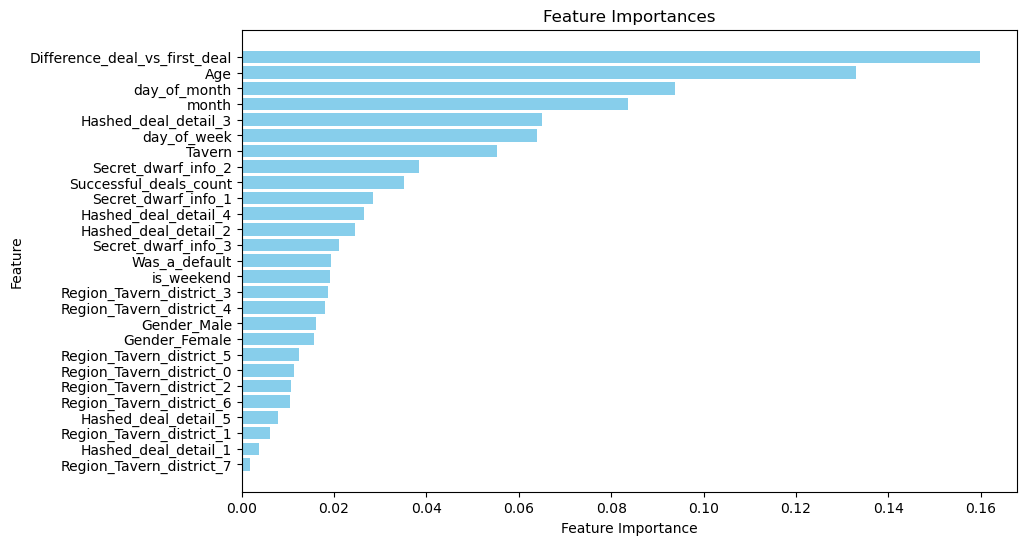

In [20]:
model = best_model.named_steps['RF']

importances = model.feature_importances_

# Create a dataframe to display feature importances

feature_importance_df = pd.DataFrame(importances, index=X_train.columns, columns=['Importance'])
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df.index, feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display feature with highest importance at the top
plt.show()


In [21]:
pred_prob = best_model.predict_proba(df_to_predict)[:, 1]

data = {
    'Deal_id': ids,
    'Prediction': pred_prob
}

# Create DataFrame
answer = pd.DataFrame(data)

answer.to_csv('prediction.csv')